In [1]:
import os
import shutil
import pandas as pd
pd.set_option('display.max_colwidth', None)
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install geopy
from geopy.geocoders import Nominatim
loc = Nominatim(user_agent="GetLoc")

In [3]:
from google.cloud import storage

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [5]:
#twt_df=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kishorkumarreddy/filtered_files_for_analysis_1')
twt_df=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kishorkumarreddy/filtered_data_for_analysis_1')

23/03/09 06:21:26 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
twt_df.createOrReplaceTempView("twt_df")

In [7]:
query = '''
select created_at, coordinates.coordinates as cr,
user.screen_name as handle_name,
user.description as desc,
user.location as user_location,
user.verified as is_verified
from twt_df'''
tw_geo = spark.sql(query)

In [8]:
tw_geo.createOrReplaceTempView("tw_geo")

In [9]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

key,value
spark.sql.legacy....,LEGACY


In [10]:
tw_geo_a = tw_geo.select(col("user_location"),col("created_at"),to_date(col("created_at"),'EEE MMM d HH:mm:ss z yyyy').alias("date"))

In [11]:
tw_geo_a.createOrReplaceTempView("tw_geo_a")

In [12]:
spark.sql("select date, user_location, count(*) from tw_geo_a where user_location is not null group by date, user_location order by count(*) desc limit 10").toPandas()

,date,user_location,count(1)
0,2022-09-18,India,647
1,2022-05-16,South Africa,305
2,2022-11-03,United Sates,259
3,2022-05-16,"Johannesburg, South Africa",244
4,2022-09-14,"Patna, India",208
5,2022-09-18,"New Delhi, India",202
6,2022-05-17,South Africa,200
7,2022-09-14,"Gaya, India",185
8,2022-09-10,"Michigan, USA",184
9,2022-10-02,🗻,181


In [13]:
tw_geo.createOrReplaceTempView("tw_geo")

In [14]:
td = spark.sql('select user_location,count(*) from tw_geo group by user_location order by count(*) desc limit 200').toPandas()

In [15]:
td['country'] = ''
for i in range(len(td)):
    if td['user_location'][i] != None:
        getLoc = loc.geocode(td['user_location'][i])
        if getLoc != None:
            td['country'][i] = getLoc.address.split(',')[-1]

/tmp/ipykernel_18805/3657135711.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td['country'][i] = getLoc.address.split(',')[-1]


In [16]:
for i in range(0,len(td)):
    td['country'][i] = td['country'][i].lstrip()

/tmp/ipykernel_18805/1624457845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td['country'][i] = td['country'][i].lstrip()


In [17]:
df_country = td.groupby(['country']).sum()

In [18]:
df_country.reset_index(inplace=True)


In [19]:
df_country.drop([0],inplace=True)

In [20]:
df_country['country_latitude'] = 0.0
df_country['country_longitude'] = 0.0
for i in range(1,len(df_country)):
    if df_country['country'][i] != None:
        getLoc = loc.geocode(df_country['country'][i])
        if getLoc != None:
            df_country['country_latitude'][i] = getLoc.latitude
            df_country['country_longitude'][i] = getLoc.longitude

/tmp/ipykernel_18805/905291699.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_latitude'][i] = getLoc.latitude
/tmp/ipykernel_18805/905291699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_longitude'][i] = getLoc.longitude


In [21]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed
No handles with labels found to put in legend.


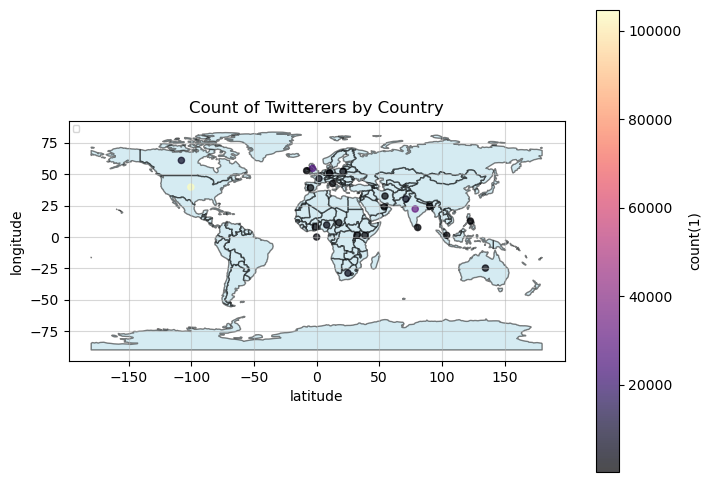

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd

# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color='lightblue', alpha=0.5, edgecolor='black', ax=ax)

# plot points
df_country.plot(x="country_longitude", y="country_latitude", kind="scatter", 
         c="count(1)", colormap="magma", alpha=0.7,
         ax=ax)

# add grid
ax.grid(b=True, alpha=0.5)

# set title and legend
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Count of Twitterers by Country')
plt.legend(loc=2, prop={'size': 6})

# show plot
plt.show()


In [23]:
df_country

,country,count(1),country_latitude,country_longitude
1,Africa,342,11.502434,17.757812
2,Australia,2027,-24.776109,134.755000
3,Canada,7665,61.066692,-107.991707
4,Deutschland,435,51.163818,10.447831
5,España,429,39.326068,-4.837979
6,France,2063,46.603354,1.888334
7,Ghana,1146,8.030028,-1.080027
8,India,32762,22.351115,78.667743
9,Italia,534,42.638426,12.674297
10,Kenya,1465,1.441968,38.431398


No handles with labels found to put in legend.
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2434 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-package

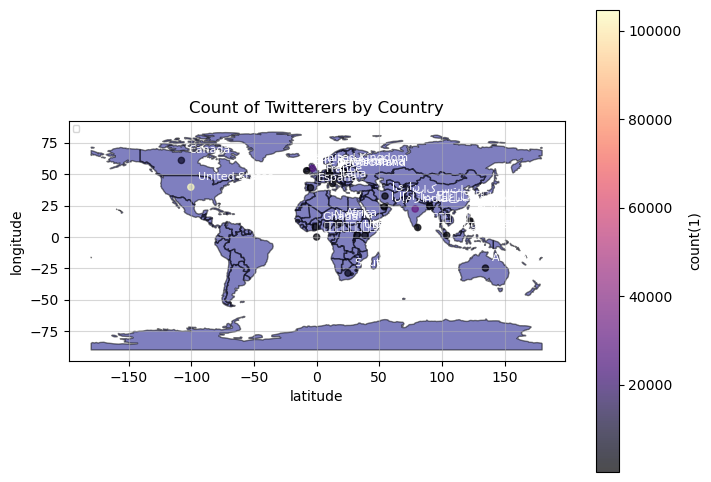

In [24]:
#We can annotate the graph to give the labels to the countries

import matplotlib.pyplot as plt
import geopandas as gpd

# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color='navy', alpha=0.5, edgecolor='black', ax=ax)

# plot points
df_country.plot(x="country_longitude", y="country_latitude", kind="scatter", 
         c="count(1)", colormap="magma", alpha=0.7,
         ax=ax)

# add labels to points
for i, row in df_country.iterrows():
    ax.annotate(row["country"], xy=(row["country_longitude"], row["country_latitude"]), 
                xytext=(5, 5), textcoords="offset points", color="white", fontsize=8)

# add grid
ax.grid(b=True, alpha=0.5)

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Count of Twitterers by Country')
plt.legend(loc=2, prop={'size': 6})

# show plot
plt.show()


In [25]:
df_cont = df_country.sort_values(by=['count(1)'], ascending=False)

In [26]:
c = df_cont.head(5)
c

,country,count(1),country_latitude,country_longitude
17,United States,104696,39.783730,-100.445882
8,India,32762,22.351115,78.667743
16,United Kingdom,26270,54.702354,-3.276575
3,Canada,7665,61.066692,-107.991707
23,پاکستان,4243,30.330840,71.247499


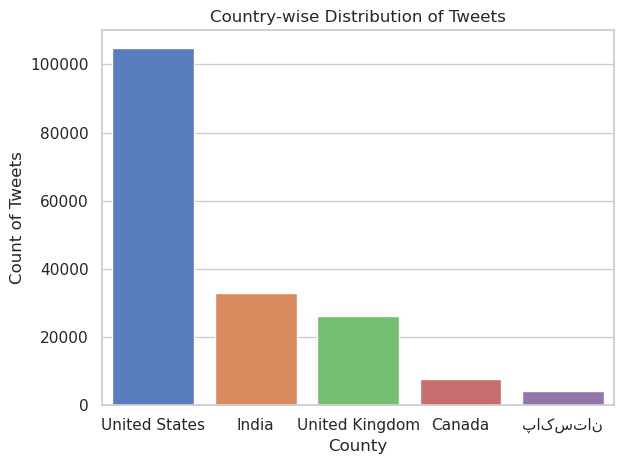

In [27]:
#sns.barplot(data=c, x="country", y="count(1)")
import seaborn as sns
import matplotlib.pyplot as plt

# set the style and color palette
sns.set(style="whitegrid", palette="muted")

# create the barplot
ax = sns.barplot(data=c,x='country', y='count(1)')

# customize the plot
plt.title("Country-wise Distribution of Tweets")
plt.xlabel("County")
plt.ylabel("Count of Tweets")
plt.ylim([0, 110000])
plt.xticks(rotation=0)
plt.tight_layout()

# show the plot
plt.show()

### What are the timelines of these tweets? Do you see significant peaks and valleys?

#### Do you see any data collection gaps?
#### Plot the timelines of these tweets

In [28]:
!break!

/bin/sh: 1: break!: not found


In [29]:
#To address these questions, we perform a time analysis. Plot a timeline graph to see the spread of the tweets

In [30]:
timeline_df = twt_df.select('id','created_at')
timeline_df.show(5)

+-------------------+--------------------+
|                 id|          created_at|
+-------------------+--------------------+
|1586426715760459778|Sat Oct 29 18:36:...|
|1586426719090589696|Sat Oct 29 18:36:...|
|1586426871524343814|Sat Oct 29 18:36:...|
|1586427143302443008|Sat Oct 29 18:38:...|
|1586427325264310273|Sat Oct 29 18:38:...|
+-------------------+--------------------+
only showing top 5 rows



In [ ]:
df_timelines_pd = timeline_df.groupby('created_at').agg(count('id').alias("count_id")).toPandas()

In [ ]:
df_timelines_pd.head(5)

In [ ]:
df_timelines_pd['created_at'] = pd.to_datetime(df_timelines_pd['created_at'])
df_timelines_pd['year'] = df_timelines_pd['created_at'].dt.year
df_timelines_pd['month'] = df_timelines_pd['created_at'].dt.month
df_timelines_pd['dayCode'] = df_timelines_pd['created_at'].dt.dayofweek

In [ ]:
df_timelines_pd.head()

,created_at,count_id,year,month,dayCode
0,2022-08-03 07:31:30+00:00,1,2022,8,2
1,2022-12-20 22:00:06+00:00,1,2022,12,1
2,2022-08-30 16:30:24+00:00,2,2022,8,1
3,2022-11-24 07:13:50+00:00,1,2022,11,3
4,2022-12-16 14:06:12+00:00,1,2022,12,4


In [ ]:
# group by the 'fruit' column and sum the 'quantity' column
result_m = df_timelines_pd.groupby('month')['count_id'].count()

# print the result
result_m.head()

month
1     98188
2     22052
4     76453
5    100171
6     83300
Name: count_id, dtype: int64

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt

#result_m.plot(x='month', y='count_id', kind='bar')
result_m.plot(x='month', y='count_id', kind='line')
plt.show()
"""

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n#result_m.plot(x='month', y='count_id', kind='bar')\nresult_m.plot(x='month', y='count_id', kind='line')\nplt.show()\n"

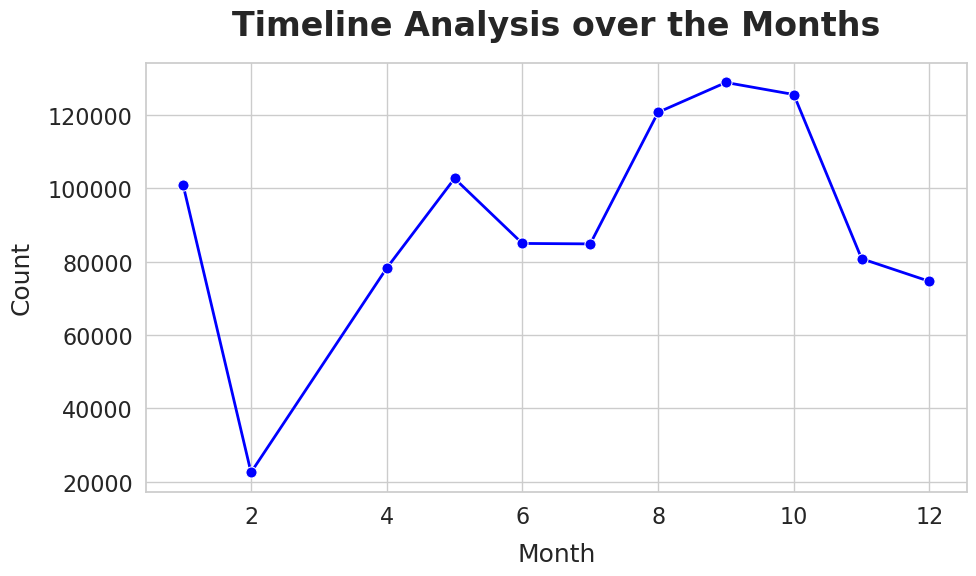

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# group by the 'month' column and sum the 'count_id' column
result_m = df_timelines_pd.groupby('month')['count_id'].sum()

# set seaborn style and plot the counts by month
sns.set(style='whitegrid', font_scale=1.2, rc={'figure.figsize':(10,6)})
sns.lineplot(x=result_m.index, y=result_m.values, color='blue', linewidth=2, marker='o', markersize=8)

# add labels and formatting
plt.title('Timeline Analysis over the Months', fontsize=24, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Count', fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# group by the 'fruit' column and sum the 'quantity' column
result = df_timelines_pd.groupby('year')['count_id'].count()

# print the result
result.head()

year
2022    851826
2023    120240
Name: count_id, dtype: int64

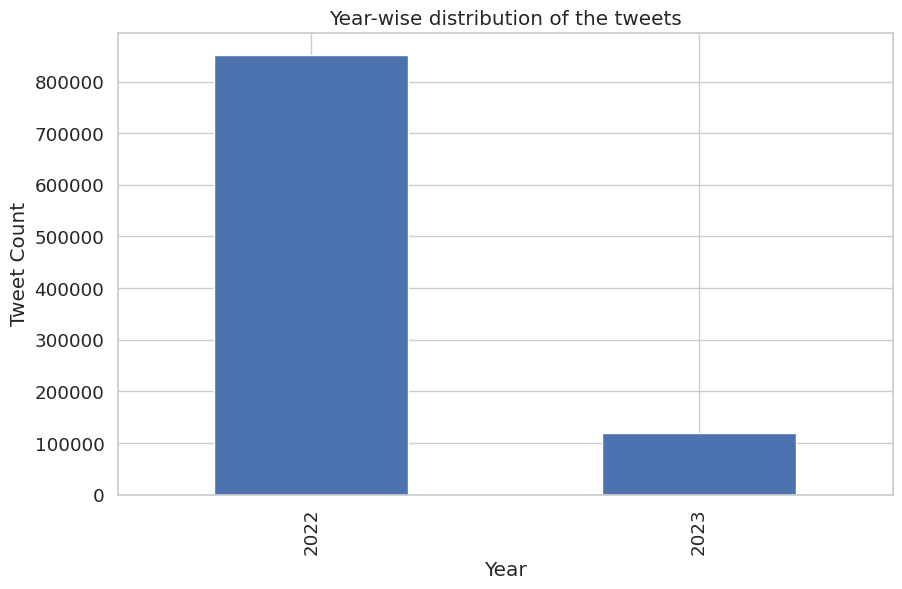

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

result.plot(x='month', y='count_id', kind='bar')

plt.title('Year-wise distribution of the tweets')
plt.xlabel('Year')
plt.ylabel('Tweet Count')
plt.show()

In [ ]:
df_timelines_pd['dayCode'].head(10)

0    2
1    1
2    1
3    3
4    4
5    5
6    0
7    0
8    1
9    0
Name: dayCode, dtype: int64

In [ ]:
# group by the 'fruit' column and sum the 'quantity' column
result_c = df_timelines_pd.groupby('dayCode')['count_id'].count()

# print the result
result_c.head()

dayCode
0    156197
1    145568
2    154594
3    146521
4    137721
Name: count_id, dtype: int64

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt

#result_m.plot(x='month', y='count_id', kind='bar')
result_c.plot(x='dayCode', y='count_id', kind='line')
plt.show()
"""

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n#result_m.plot(x='month', y='count_id', kind='bar')\nresult_c.plot(x='dayCode', y='count_id', kind='line')\nplt.show()\n"

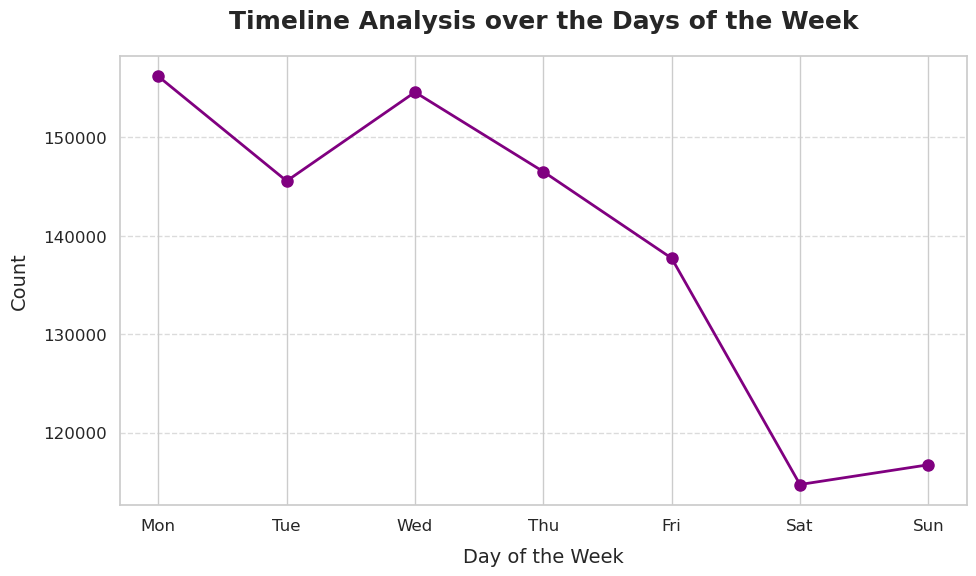

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# group by the 'dayCode' column and count the IDs for each dayCode
result_c = df_timelines_pd.groupby('dayCode')['count_id'].count().reset_index()

# plot the counts by dayCode
plt.plot(result_c['dayCode'], result_c['count_id'], color='purple', linewidth=2, linestyle='-', marker='o', markersize=8)
plt.title('Timeline Analysis over the Days of the Week', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Day of the Week', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(result_c['dayCode'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df_timelines_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972066 entries, 0 to 972065
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   created_at  972066 non-null  datetime64[ns, UTC]
 1   count_id    972066 non-null  int64              
 2   year        972066 non-null  int64              
 3   month       972066 non-null  int64              
 4   dayCode     972066 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4)
memory usage: 37.1 MB


In [ ]:
df_timelines_pd['day'] = df_timelines_pd['created_at'].dt.day

In [ ]:

"""
import pandas as pd
import matplotlib.pyplot as plt

# group by the 'fruit' column and sum the 'quantity' column
result_d = df_timelines_pd.groupby('day')['count_id'].count()

#result_m.plot(x='month', y='count_id', kind='bar')
result_d.plot(x='day', y='count_id', kind='line')
plt.title('Timeline Analysis over the day of the month')
plt.show()
"""

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# group by the 'fruit' column and sum the 'quantity' column\nresult_d = df_timelines_pd.groupby('day')['count_id'].count()\n\n#result_m.plot(x='month', y='count_id', kind='bar')\nresult_d.plot(x='day', y='count_id', kind='line')\nplt.title('Timeline Analysis over the day of the month')\nplt.show()\n"

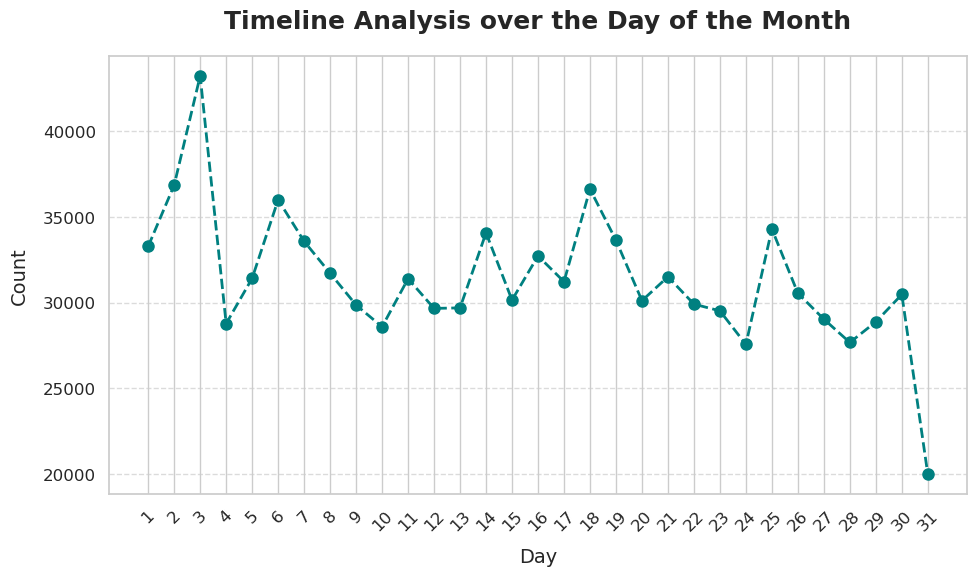

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# group by the 'day' column and count the IDs for each day
result_d = df_timelines_pd.groupby(df_timelines_pd['created_at'].dt.day)['count_id'].count().reset_index()

# plot the counts by day
plt.plot(result_d['created_at'], result_d['count_id'], color='teal', linewidth=2, linestyle='--', marker='o', markersize=8)
plt.title('Timeline Analysis over the Day of the Month', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Day', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(result_d['created_at'], result_d['created_at'], fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt

# group by the 'day' column and count the IDs for each day
result_d = df_timelines_pd.groupby(df_timelines_pd['created_at'])['count_id'].count().reset_index()

# plot the counts by day
plt.plot(result_d['created_at'], result_d['count_id'], color='teal', linewidth=2, linestyle='--', marker='o', markersize=8)
plt.title('Timeline Analysis over the Day of the Month', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Day', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(result_d['created_at'], result_d['created_at'], fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
"""

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# group by the 'day' column and count the IDs for each day\nresult_d = df_timelines_pd.groupby(df_timelines_pd['created_at'])['count_id'].count().reset_index()\n\n# plot the counts by day\nplt.plot(result_d['created_at'], result_d['count_id'], color='teal', linewidth=2, linestyle='--', marker='o', markersize=8)\nplt.title('Timeline Analysis over the Day of the Month', fontsize=18, fontweight='bold', pad=20)\nplt.xlabel('Day', fontsize=14, labelpad=10)\nplt.ylabel('Count', fontsize=14, labelpad=10)\nplt.xticks(result_d['created_at'], result_d['created_at'], fontsize=12, rotation=45)\nplt.yticks(fontsize=12)\nplt.grid(axis='y', linestyle='--', alpha=0.7)\nplt.tight_layout()\nplt.show()\n"

In [ ]:
timeline_df = twt_df.select('id','created_at')
timeline_df.show(5)

+-------------------+--------------------+
|                 id|          created_at|
+-------------------+--------------------+
|1586426715760459778|Sat Oct 29 18:36:...|
|1586426719090589696|Sat Oct 29 18:36:...|
|1586426871524343814|Sat Oct 29 18:36:...|
|1586427143302443008|Sat Oct 29 18:38:...|
|1586427325264310273|Sat Oct 29 18:38:...|
+-------------------+--------------------+
only showing top 5 rows

